<a href="https://colab.research.google.com/github/Deok-Hun/Aiffel_Kun/blob/master/EX_4_%EC%A3%BC%EC%8B%9D_%EC%98%88%EC%B8%A1%EC%97%90_%EB%8F%84%EC%A0%84%ED%95%B4_%EB%B3%B4%EC%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.5
1.0.2
0.12.2


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 시계열 데이터 준비

In [38]:
os.environ['HOME']=''
print(os.getenv('HOME'))

In [39]:
dataset_filepath=os.getenv('HOME')+'/content/drive/MyDrive/Exploration/Exploration_4/data/AAPL.csv'
df=pd.read_csv(dataset_filepath)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-09-20,143.800003,144.839996,141.270004,142.940002,142.143494,123478900
1,2021-09-21,143.929993,144.600006,142.779999,143.429993,142.630753,75834000
2,2021-09-22,144.449997,146.429993,143.699997,145.850006,145.037277,76404300
3,2021-09-23,146.649994,147.080002,145.639999,146.830002,146.011826,64838200
4,2021-09-24,145.660004,147.470001,145.559998,146.919998,146.101303,53477900


In [40]:
df=pd.read_csv(dataset_filepath, index_col='Date',parse_dates=True)

ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2021-09-20    142.940002
2021-09-21    143.429993
2021-09-22    145.850006
2021-09-23    146.830002
2021-09-24    146.919998
Name: Close, dtype: float64

# 각종 전처리 수행

In [41]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

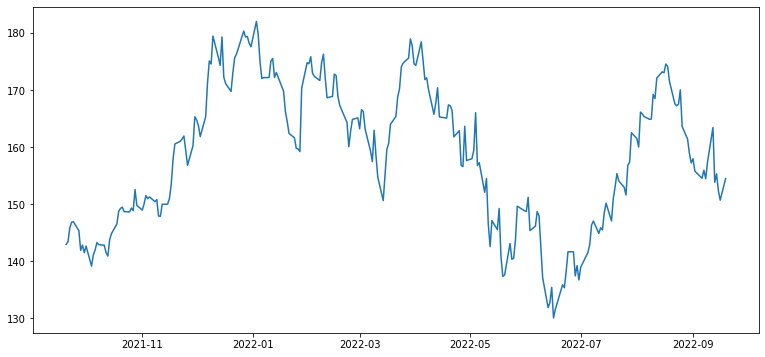

In [42]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=13,6

plt.plot(ts)

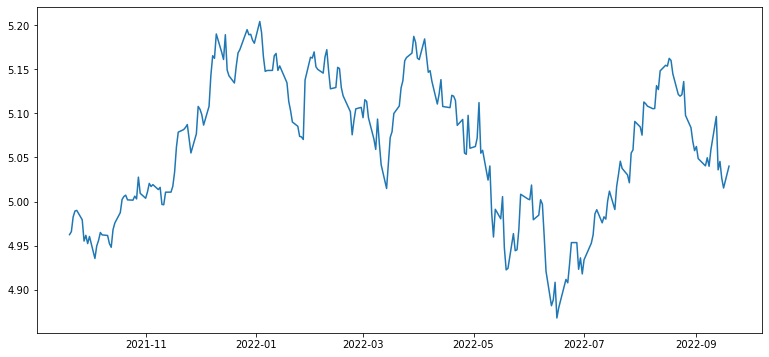

In [43]:
ts_log=np.log(ts)
plt.plot(ts_log)

# 시계열 안정성 분석

  * 정성적 그래프 분석
  * 정량적 Augmented Dicky-Fuller Test
  * 시계열 분해 Time Series Decomposition
  * Redisual 안정성 확인

In [44]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [45]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
  
  # statsmodels 패키지에서 제공하는 adfuller 메서드 호출
  dftest = adfuller(timeseries, autolag = 'AIC')

  # adfuller 메서드가 리턴한 결과를 정리하여 출력
  print('Results of Dickey-Fuller Test:')
  
  dfoutput = pd.Series(dftest[0:4], index = ['Tset Statistic', 'p-value', '#Lags Used','Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
  
  print(dfoutput)

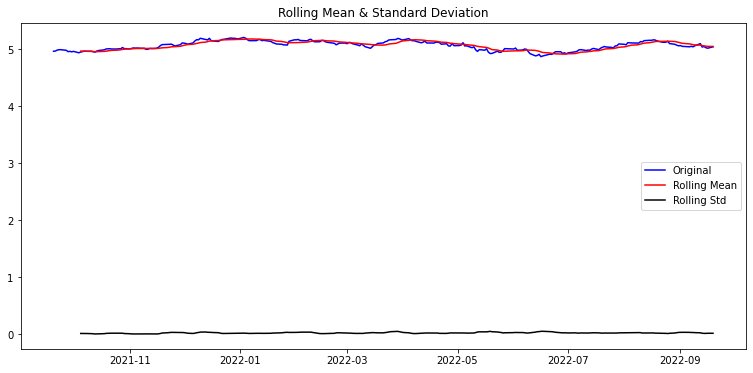

Results of Dickey-Fuller Test:
Tset Statistic                  -2.171407
p-value                          0.216786
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


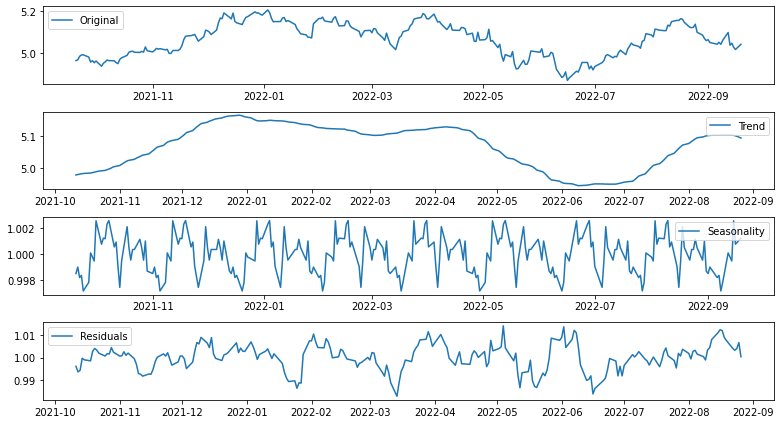

In [46]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model = 'multiplicative', period = 30)

trend = decomposition.trend            # 추세(시간 추이에 따르ㅏ 나타나는 평균값 변화)
seasonal = decomposition.seasonal      # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid         # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"]= (11,6)

plt.subplot(411)
plt.plot(ts_log, label= 'Original')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label= 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label= 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual, label= 'Residuals')
plt.legend(loc = 'best')

plt.tight_layout()


In [47]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Tset Statistic                  -4.922544
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


# 학습, 테스트 데이터셋 생성

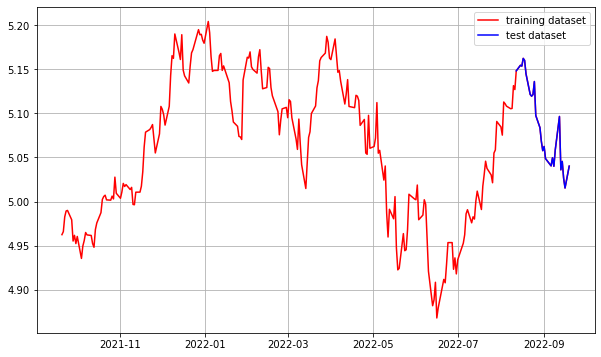

In [48]:
# 훈련 9 : 테스트 1
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data 를 적용하면 끊겨 보인다.
plt.plot(test_data, c='b', label='test dataset') 
plt.legend()

# 적정 ARIMA 모수 찾기

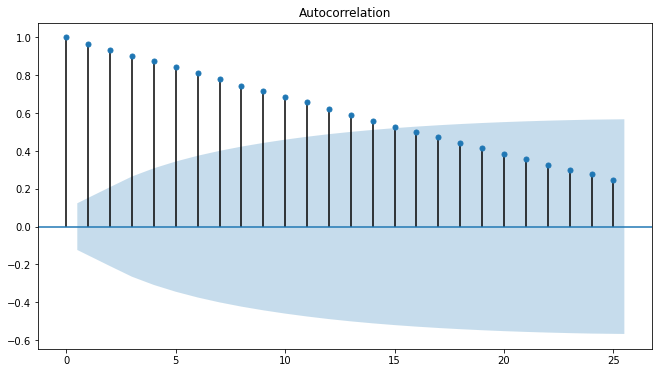

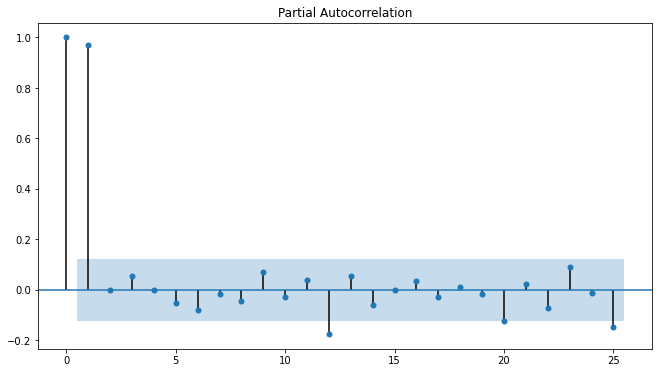

In [49]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Tset Statistic                -1.601270e+01
p-value                        6.329971e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Tset Statistic                -7.914125e+00
p-value                        3.877038e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


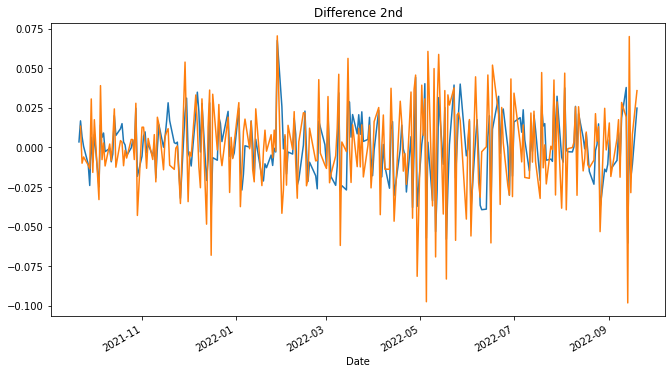

In [50]:
# 차분 안정성 확인 -> d 구하기
diff_1=ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title = 'Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# ARIMA 모델 훈련과 테스트


In [51]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [70]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA

# Build Model
model = ARIMA(train_data, order=(2,0,2))
fitted_m=model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  226
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 566.645
Date:                Tue, 20 Sep 2022   AIC                          -1121.290
Time:                        10:18:34   BIC                          -1100.767
Sample:                             0   HQIC                         -1113.008
                                - 226                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0551      0.039    129.256      0.000       4.978       5.132
ar.L1          0.7952      1.416      0.562      0.574      -1.980       3.570
ar.L2          0.1711      1.370      0.125      0.9

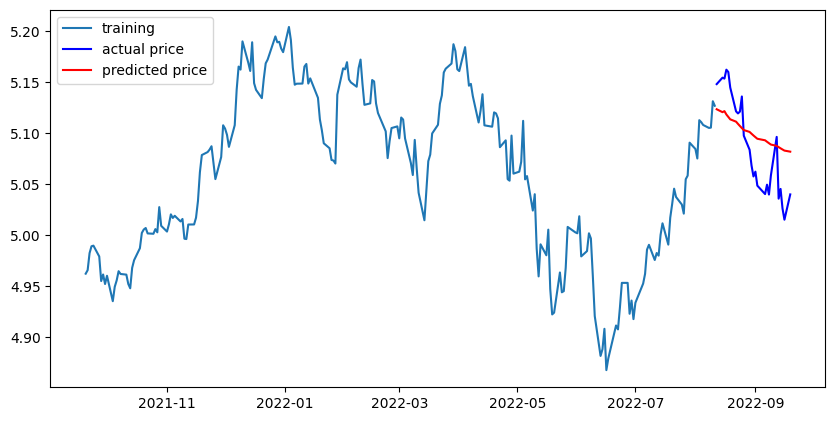

In [105]:
# Forecast : 결과가 fc에 담긴다.


model=ARIMA(train_data, order=(2,0,4))
fitted_m = model.fit()

fc=fitted_m.forecast(len(test_data),alpha=0.05)
fc=np.array(fc)

fc_series = pd.Series(fc, index = test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [106]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data),np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data),np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc)-np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  36.9362421099141
MAE:  5.548128782593734
RMSE:  6.077519404322301
MAPE: 3.46%
